# Learning to make a market with `mbt_gym` and `Stable Baselines 3`

### Import external modules

In [41]:
from copy import deepcopy
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

### Add mbt-gym to path and import

In [42]:
import sys
sys.path.append("../../")

from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import ReduceStateSizeWrapper
from mbt_gym.rewards.RewardFunctions import CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.agents.SbAgent import SbAgent

# Create market making environment

Section 10.2 of [Cartea, Jaimungal and Penalva (2015)](https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance-ebook/dp/B012GS2MY0)

In [43]:
sigma= 0.01 # constant "volatility" of mid-price process
arrival_rate = 30.0 # lambda 
fill_exponent = 100 # kappa
alpha = 0.0001 # terminal inventory penalty (fees of market orders and walking the book)
phi = 0.0002 # running inventory penalty parameter

terminal_time = 1.0 # time [0,1]
max_inventory = 3
initial_inventory = (-3,4) # initial inventory will be random integer from {-3,-2,...,2,3}
initial_price = 100

n_steps = int(10 * terminal_time * arrival_rate)
step_size = 1/n_steps

## Some standard aproaches to help learning

### Normalising the observation space

- time $t \in [0,T]$
- inventory in $[-\texttt{max_inv},\texttt{max_inv}]$
- *agent's cash* and the *asset price* are technically unbounded 
- however, we bound them since most of the modern implementations of deep reinforcement learning algorithms assume a "box" observation space

### Normalising the action space

- We will also normalise the action space 
- We assume that the agent places orders at a maximum spread such that the order gets filled with a probability $\mathbb{P}(\text{fill}) = 0.01$.
- In both cases we normalise the observation and action spaces   linearly, so that all observations and actions lie in $[-1,1]$

### Initial inventory randomisation

- aids learning to randomly initialise the starting inventory of the learning agent (even if we only ultimately care about the problem when the agent starts with 0 inventory) 
- this helps the agent to see more of the state space and  accelerates learning
- uniformly sample the starting inventory from $$\{-\texttt{max_inv},\dots,\texttt{max_inv}\}$$

In [44]:
normalise_observation_space = True
normalise_action_space = True

In [45]:
def get_cj_env(num_trajectories:int = 1, 
               normalise_observation_space:bool = False, 
               normalise_action_space:bool = False):    
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps, 
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = CjMmCriterion(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=max_inventory,
                      normalise_action_space = normalise_action_space,
                      normalise_observation_space = normalise_observation_space,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [46]:
num_trajectories = 1000
original_env = get_cj_env(num_trajectories, 
                                        normalise_observation_space=normalise_observation_space, 
                                        normalise_action_space=normalise_action_space)
wrapped_env = ReduceStateSizeWrapper(original_env)
sb_env = StableBaselinesTradingEnvironment(trading_env=wrapped_env)

# Monitor sb_env for tensorboard logging
sb_env = VecMonitor(sb_env)

# Add directory for tensorboard logging and best model
tensorboard_logdir = "./tensorboard/PPO-learning-CJ/"

### Define PPO policy

In [47]:
policy_kwargs = dict(net_arch=[dict(pi=[32, 32], vf=[32, 32])])
PPO_params = {"policy":'MlpPolicy', 
              "env": sb_env, 
              "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":10,
              "batch_size": int(n_steps * num_trajectories / 10), 
              "n_steps": int(n_steps),
              "learning_rate":0.001,}
model = PPO(**PPO_params, device="cuda")

Using cpu device


In [48]:
model.learn(total_timesteps = 10_000_000)  # 100_000_000 Increase number of training timesteps according to computing resources

Logging to ./tensorboard/PPO-learning-CJ/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 300      |
|    ep_rew_mean     | 0.074159 |
| time/              |          |
|    fps             | 865004   |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 300000   |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 300        |
|    ep_rew_mean          | 0.08260305 |
| time/                   |            |
|    fps                  | 276498     |
|    iterations           | 2          |
|    time_elapsed         | 2          |
|    total_timesteps      | 600000     |
| train/                  |            |
|    approx_kl            | 0.0047123  |
|    clip_fraction        | 0.0274     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.758      

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 300         |
|    ep_rew_mean          | 0.06484845  |
| time/                   |             |
|    fps                  | 173835      |
|    iterations           | 11          |
|    time_elapsed         | 18          |
|    total_timesteps      | 3300000     |
| train/                  |             |
|    approx_kl            | 0.003615567 |
|    clip_fraction        | 0.0192      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.52       |
|    explained_variance   | 0.802       |
|    learning_rate        | 0.001       |
|    loss                 | -0.000854   |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.000917   |
|    std                  | 0.85        |
|    value_loss           | 7.3e-05     |
-----------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 300          |
|    ep_rew_mean          | 0.094379045  |
| time/                   |              |
|    fps                  | 167500       |
|    iterations           | 20           |
|    time_elapsed         | 35           |
|    total_timesteps      | 6000000      |
| train/                  |              |
|    approx_kl            | 0.0028583105 |
|    clip_fraction        | 0.0114       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.28        |
|    explained_variance   | 0.402        |
|    learning_rate        | 0.001        |
|    loss                 | -0.000169    |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.000654    |
|    std                  | 0.756        |
|    value_loss           | 5.95e-05     |
------------------------------------------
------------------------------------------
| rollout/ 

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 300        |
|    ep_rew_mean          | 0.11029329 |
| time/                   |            |
|    fps                  | 162809     |
|    iterations           | 29         |
|    time_elapsed         | 53         |
|    total_timesteps      | 8700000    |
| train/                  |            |
|    approx_kl            | 0.00216304 |
|    clip_fraction        | 0.0119     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.85      |
|    explained_variance   | 0.542      |
|    learning_rate        | 0.001      |
|    loss                 | -0.000742  |
|    n_updates            | 280        |
|    policy_gradient_loss | -0.000695  |
|    std                  | 0.608      |
|    value_loss           | 5.97e-05   |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

In [49]:
# Save the model (already done so commented out)
#model.save("PPO-learning-CJP-tutorial_10M")

### Example learning curves

#### Agent rewards

<img src="images/train_rew.png"  width=80% height=80%>

#### The agent's policy standard deviation

<img src="images/train_std.png"  width=80% height=80%>

#### The explained variance

<img src="images/train_exp_var.png"  width=80% height=80%>

## Comparing the learnt policy to the optimal policy

To compare the learnt policy to the known optimal policy from Chapter 10.2 of [Cartea, Jaimungal and Penalva (2015)](https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance-ebook/dp/B012GS2MY0) we introduce the following helpers for plotting:

In [50]:
def create_data_for_plots(model: PPO, time_of_action: float = 0.5):    
    ppo_agent = SbAgent(model, num_trajectories=1)
    cj_agent = CarteaJaimungalMmAgent(env=get_cj_env())
    single_cj_env = get_cj_env(normalise_observation_space=normalise_observation_space, 
                               normalise_action_space=normalise_action_space)
    inventories = np.arange(-max_inventory,max_inventory+1,1)  
    times = np.arange(0, single_cj_env.terminal_time + 0.01, 0.01)
    inventory_dict = {inventory: {} for inventory in inventories}
    action_dict = {
        r"RL $\delta^+$": deepcopy(inventory_dict), r"CJP $\delta^+$": deepcopy(inventory_dict),
        r"RL $\delta^-$": deepcopy(inventory_dict), r"CJP $\delta^-$": deepcopy(inventory_dict),
    }
    for inventory in inventories:
        for time in times:
            obs = np.array([[0, inventory, time, 100]])
            if normalise_observation_space: obs = single_cj_env.normalise_observation(obs)
            obs = obs[:,1:3]; action = ppo_agent.get_action(obs).reshape(-1)
            if normalise_action_space: action = single_cj_env.normalise_action(action, inverse=True)
            bid_action, ask_action = action
            cj_bid_action, cj_ask_action = cj_agent.get_action(np.array([[0,inventory,time, 0]])).reshape(-1)
            if inventory == -max_inventory:
                ask_action = np.NaN; cj_ask_action = np.NaN
            if inventory == max_inventory:
                bid_action = np.NaN; cj_bid_action = np.NaN
            action_dict[r"RL $\delta^+$"][inventory][time] = bid_action
            action_dict[r"CJP $\delta^+$"][inventory][time] = cj_bid_action
            action_dict[r"RL $\delta^-$"][inventory][time] = ask_action
            action_dict[r"CJP $\delta^-$"][inventory][time] = cj_ask_action
 
    return times, inventories, action_dict

In [52]:
def plot0(inventories, action_dict, time_of_action: float = 0.5):
    # just the optimal actions at specific time
    plt.plot(inventories, [action_dict[r"CJP $\delta^+$"][inventory][time_of_action] for inventory in inventories],
             label=r"CJP $\delta^+$", color="k", linestyle="--")
    plt.plot(inventories, [action_dict[r"CJP $\delta^-$"][inventory][time_of_action] for inventory in inventories],
             label=r"CJP $\delta^-$", color="r", linestyle="--")
    plt.legend()
    plt.title(fr"The optimal agent's actions $\delta^\pm$ at time {time_of_action}")
    plt.ylabel(r"Depth ($\delta$)")
    plt.xlabel(r"Inventory")
    plt.show()

In [53]:
def plot1(inventories, action_dict, time_of_action: float = 0.5):
    # the optimal actions and learnt actions on one plot at specific time
    plt.plot(inventories, [action_dict[r"RL $\delta^+$"][inventory][time_of_action] for inventory in inventories],
             label=r"RL $\delta^+$", color="k")
    plt.plot(inventories, [action_dict[r"CJP $\delta^+$"][inventory][time_of_action] for inventory in inventories],
             label=r"CJP $\delta^+$", color="k", linestyle="--")
    plt.plot(inventories, [action_dict[r"RL $\delta^-$"][inventory][time_of_action] for inventory in inventories],
             label=r"RL $\delta^-$", color="r")
    plt.plot(inventories, [action_dict[r"CJP $\delta^-$"][inventory][time_of_action] for inventory in inventories],
             label=r"CJP $\delta^-$", color="r", linestyle="--")
    plt.legend()
    plt.title(fr"The agent's learnt actions $\delta^\pm$ at time {time_of_action}")
    plt.ylabel(r"Depth ($\delta$)")
    plt.xlabel(r"Inventory")
    plt.show()
 

In [54]:
def plot2(action_dict, times):
    # optimal and learnt actions over time
    fig, axs = plt.subplots(2, 2, sharey=True, figsize=(15, 10))
    for count, (name, actions) in enumerate(action_dict.items()):
        axs[count // 2, count % 2].set_title(name, fontsize=20)
        if count ==2 or count == 3:
            axs[count // 2, count % 2].set_xlabel("Time (secs)", fontsize=20)
        for inventory in inventories:
            if count in (0,1) and inventory == 3 or count in (2,3) and inventory == -3:
                continue
            axs[count // 2, count % 2].plot(times, actions[inventory].values(), label=f"Inventory = {inventory}")
        if count ==0 or count == 2: 
            axs[count // 2, count % 2].legend(loc=2)
    fig.tight_layout()
    plt.show()   

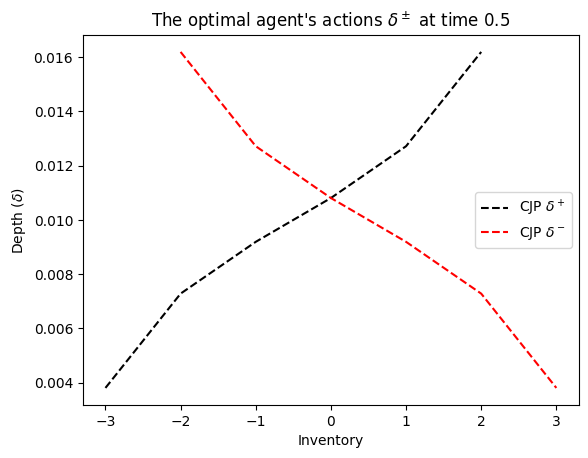

In [56]:
times, inventories, action_dict = create_data_for_plots(model)
plot0(inventories, action_dict)

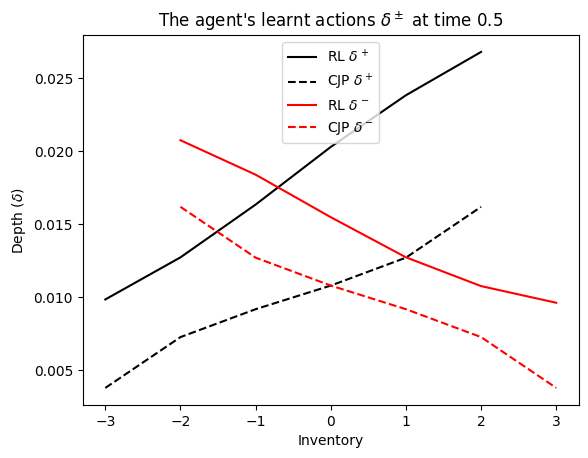

In [57]:
plot1(inventories, action_dict)

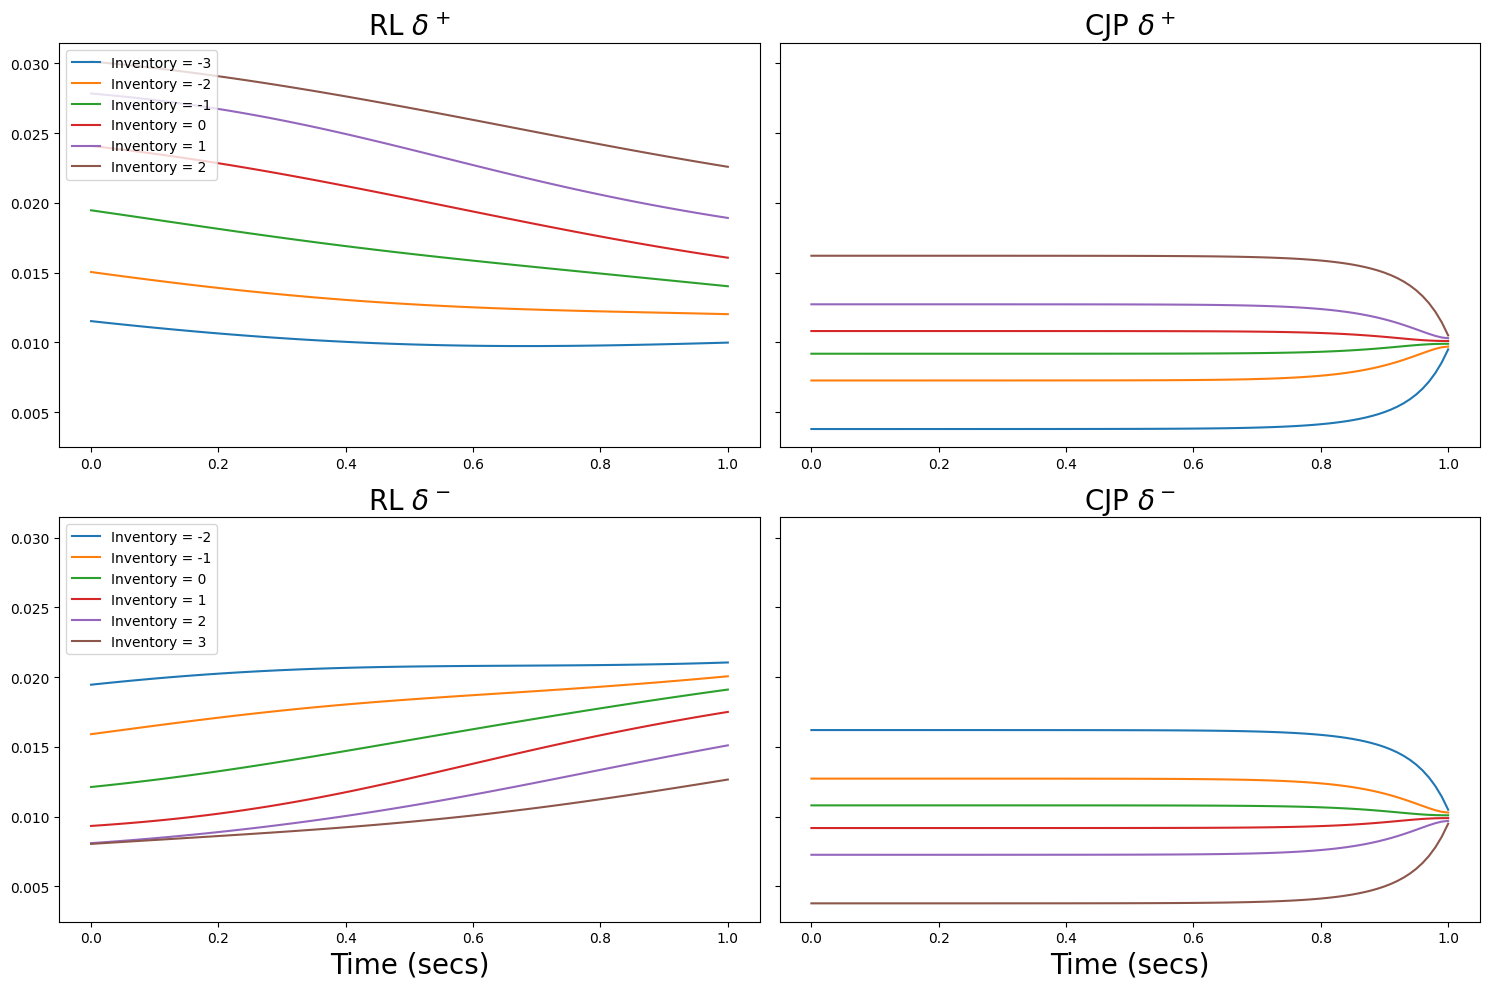

In [58]:
plot2(action_dict, times)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


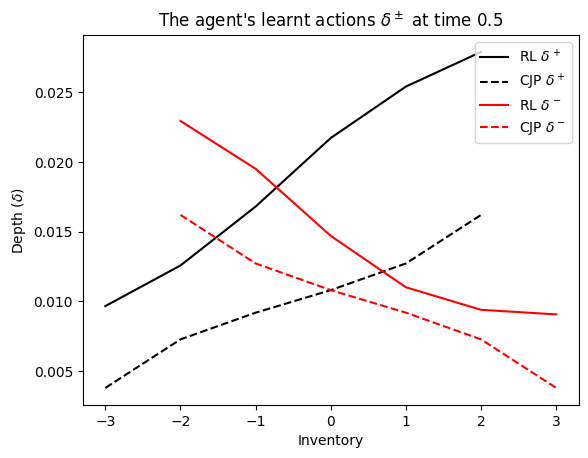

In [59]:
model = PPO.load("PPO-learning-CJP-10M", env=wrapped_env)
times, inventories, action_dict = create_data_for_plots(model)
plot1(inventories, action_dict)

### Notes on this learning

- The agent learns the shape of the optimal action as a function of inventory fairly well
- It learns to skew the bid spread up and the ask half-spread down when it has a positive inventory and vice-versa
- The agent does not learn the optimal action as a function of time very well at all
- We will see about improving this next...

## Improving learning

Now we add some further improvements to the learning process... 

### Initial time randomisation

- To further improve the agent's exposure to various parts of the state space, it might also help to randomly sample the *initial start time* as well as the initial inventory

- Otherwise, later on in the trajectory, the agent will not have seen parts of the state space that lie far away from the optimal trajectory

- In particular, the agent will not have seen states late in the episode that have a large absolute value of inventory, because this is sub-optimal

- Whilst this doesn't make much of a difference for learning a policy that is very close to optimal in terms of rewards, it might behave strangely further away from the optimal path

### Entropy regularisation

- [Entropy regularisation](https://arxiv.org/abs/1801.01290) is important to ensure that we continue exploring for long enough that the fine-grained details of the policy are learnt
- Without entropy regularisation, the learnt policy can reduce in variance too quickly, converging prematurely towards a suboptimal deterministic policy

### Adapting the PPO policy and critic architectures

- Instead of using the popular and default Tanh activation function, we use a ReLU activation. 
- ReLU can usefully provide a sparse representation
- This means that different parts of the policy network can learn different parts of the feature space
- To allow for this sparse representation, we use larger neural networks

In [60]:
policy_kwargs = dict(net_arch=[dict(pi=[64,64], vf=[128, 128])], activation_fn=torch.nn.modules.activation.ReLU)
PPO_params = {"policy":'MlpPolicy', 
              "env": sb_env, 
              "verbose":1, 
              "policy_kwargs":policy_kwargs, 
              "tensorboard_log":tensorboard_logdir,
              "n_epochs":10,
              "gamma":1,
              "batch_size": int(n_steps * num_trajectories),
              "normalize_advantage":True,
              "n_steps": int(n_steps * 10),
              "ent_coef": 0.001,
              "learning_rate":0.001,
             }

- We will not train an improved model now, but leave this as an exercise
- Instead we will just load one I made earlier...

In [61]:
improved_model = PPO.load("PPO-learning-CJP-improvements", env=wrapped_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


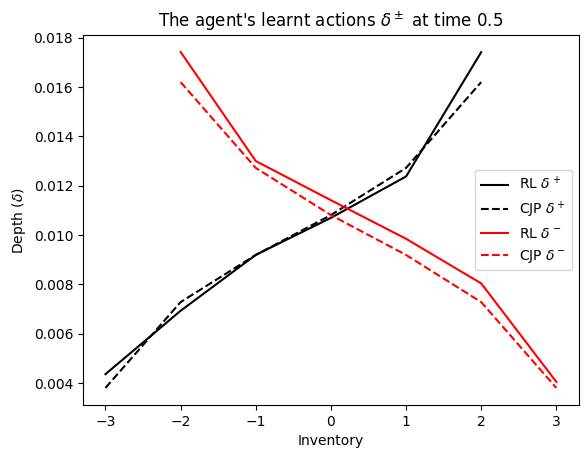

In [62]:
times, inventories, action_dict = create_data_for_plots(improved_model)
plot1(inventories, action_dict)

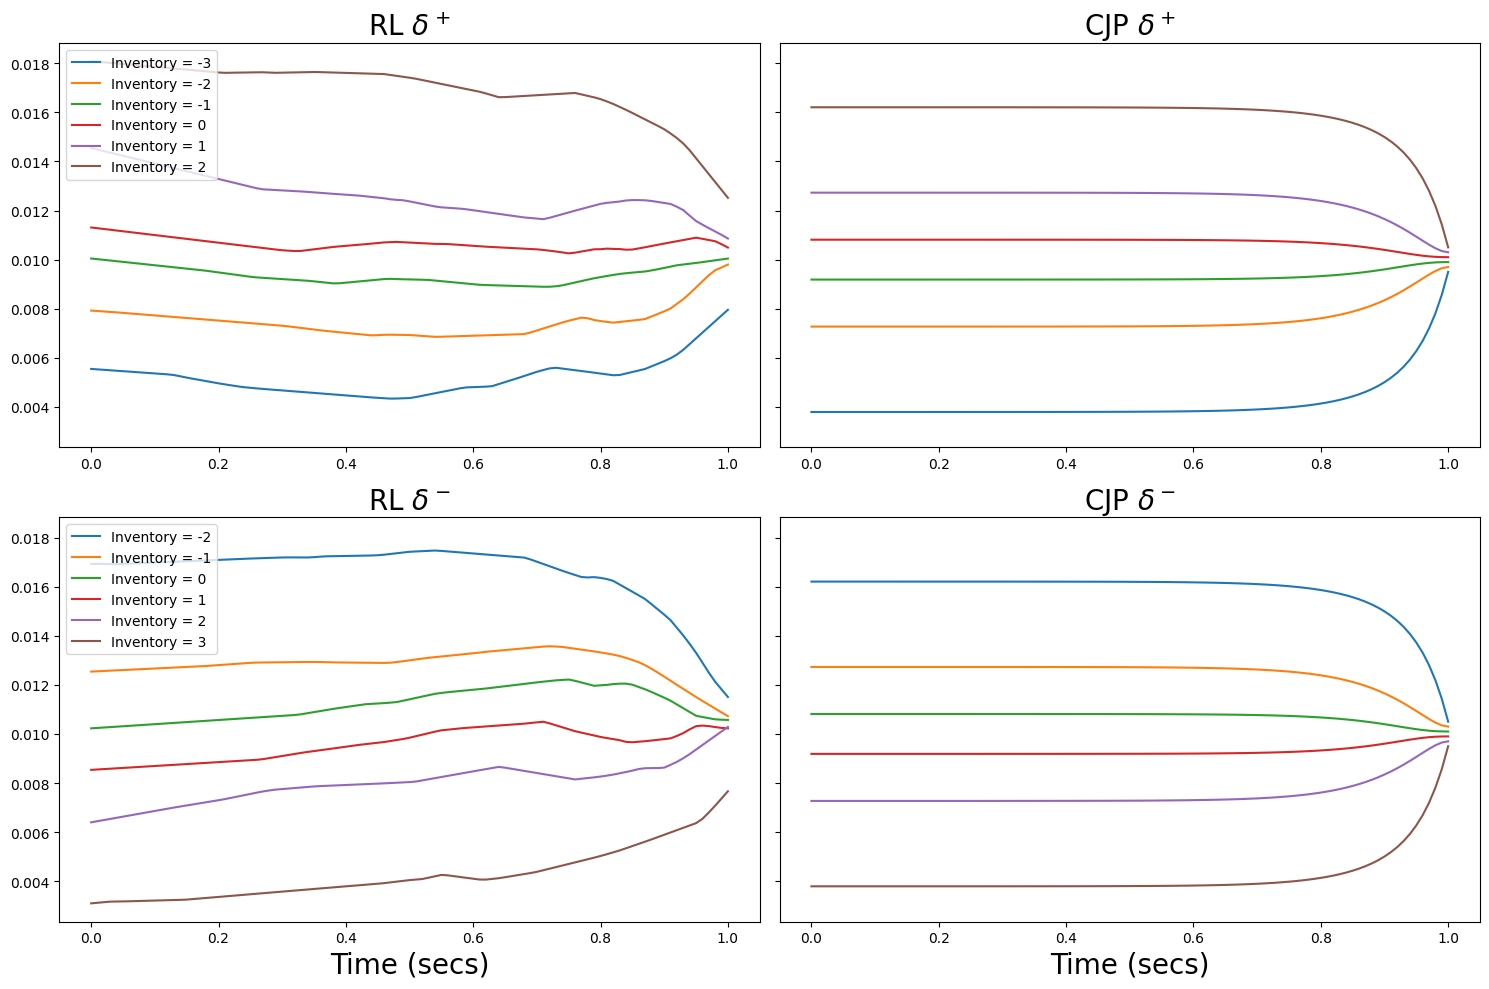

In [63]:
plot2(action_dict, times)

# There are many other things to explore in mbt-gym, including:

- other market making models
- models of optimal execution
- other RL algorithms


# The end -- thanks!